## Домашнее задание 7

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

### __Задача 1__

Дана матрица объект-признак
```
X = [[ 1.22401313,  2.30868478,  3.03636353,  2.69287214],
     [-0.18757272,  1.30337355,  5.12093014,  3.46363202],
     [-0.81094525,  1.82463398,  5.79686488,  1.86159445],
     [ 0.75129018,  2.67392052,  3.65529809,  1.66746094],
     [ 0.00972362,  1.97367255,  2.50594319,  1.69755173],
     [-0.62972637,  0.77750764,  2.84124027,  4.54410559],
     [ 2.29536229,  1.81206697,  1.95026215,  1.51874636],
     [ 0.0920418 ,  2.26971361,  7.47708735,  2.61081203],
     [ 2.39252799,  3.17563985,  3.61420599,  5.10773362],
     [ 0.54983815,  2.87988651,  1.65752765,  1.59635987]]
```
и значения целевой переменной
```
y = [ 9.26193358,  9.700363  ,  8.67214805,  8.74796974,  6.18689108,
      7.53312713,  7.57643777, 12.44965478, 14.29010746,  6.68361218]
```

1. Подберите два признака (из четырёх) так, чтобы уровень линейной зависимости целевой переменной от значений этих признаков был максимальным. Другими словами, модель линейной регрессии на этих признаках должна давать наилучший результат.
2. Является ли значимым получившееся уравнение регрессии?

In [3]:
X = pd.DataFrame([[ 1.22401313,  2.30868478,  3.03636353,  2.69287214],
                  [-0.18757272,  1.30337355,  5.12093014,  3.46363202],
                  [-0.81094525,  1.82463398,  5.79686488,  1.86159445],
                  [ 0.75129018,  2.67392052,  3.65529809,  1.66746094],
                  [ 0.00972362,  1.97367255,  2.50594319,  1.69755173],
                  [-0.62972637,  0.77750764,  2.84124027,  4.54410559],
                  [ 2.29536229,  1.81206697,  1.95026215,  1.51874636],
                  [ 0.0920418 ,  2.26971361,  7.47708735,  2.61081203],
                  [ 2.39252799,  3.17563985,  3.61420599,  5.10773362],
                  [ 0.54983815,  2.87988651,  1.65752765,  1.59635987]], columns=[f'f_{i}' for i in range(4)])
y = np.array([ 9.26193358,  9.700363  ,  8.67214805,  8.74796974,  6.18689108,
              7.53312713,  7.57643777, 12.44965478, 14.29010746,  6.68361218])

$$R^2=\frac{SS_{res}}{SS_y}=\frac{\sum_{i=1}^n(y_i-z)^2}{\sum^n_{i=1}(y_i-\overline{y})^2}$$

__Необходимо найти и сравнить $R^2$ для всех пар признаков__, но я потренируюсь делать всё (_уж простите_)

#### Сначала попробуем сделать это для отдельных признаков:

$$b_1=\frac{\overline{xy}-\overline{x}\cdot\overline{y}}{\overline{x^2}-(\overline{x})^2},\enspace
  b_0=\overline{y}-b_1\cdot\overline{x}$$

In [190]:
def find_b(x, y):
    b_1 = (np.mean(x * y) - np.mean(x) * np.mean(y)) / (np.mean(x ** 2) - np.mean(x) ** 2)
    b_0 = np.mean(y) - b_1 * np.mean(x)
#     print(b_0, b_1)
    return [b_0, b_1]

def find_R(z, y):
    return 1 - ((y - z) ** 2).sum() / ((y - np.mean(y)) ** 2).sum()

def find_best_feat(X, features: list, y):
    R = {}
    for feat in features:
        b = find_b(X[feat].values, y)
        z = b[0] + b[1] * X[feat].values
        R[feat] = find_R(z, y)
    return R

In [191]:
find_best_feat(X, [f'f_{i}' for i in range(4)], y)

{'f_0': 0.12367649337263598,
 'f_1': 0.1598866984529116,
 'f_2': 0.33946640354041757,
 'f_3': 0.3635086384600962}

Таким образом, целевая переменная имеет самый самый большой уровень линейной зависимости от `f_3`.

#### Далее для пар признаков:

$$b=(X^TX)^{-1}X^TY$$

In [202]:
def find_b2(X, y):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    XTX = X.T.dot(X)
    if np.linalg.det(XTX) == 0:
        print('Определитель матрицы ковариации равен нулю')
        return []
    XTX_inv = np.linalg.inv(XTX)
    return XTX_inv.dot(X.T).dot(y)

def predict(b: list, x):
    z = x * b[1:]
    if len(z.shape) > 1:
        z = np.array([a.sum() for a in z])
    return b[0] + z

def find_2_best_feat(X, y):
    R_all = np.array([])
    feat_pairs = []
    was = []
    for feat1 in X.columns:
        was.append(feat1)
        for feat2 in np.setdiff1d(X.columns, feat1):
            if not (feat2 in was):
                b = find_b2(X[[feat1, feat2]].values, y)
                z = predict(b, X[[feat1, feat2]].values)
                feat_pairs.append(f'{feat1}/{feat2}')
                R_all = np.append(R_all, find_R(z, y))
    max_R = R_all.max()
    R_all = np.vstack((feat_pairs, R_all)).T
    return max_R, R_all

In [203]:
best_R, R = find_2_best_feat(X, y)
print(f'Лучший коэффициент детерминации - {best_R}\nВсе значения:\n{R}')

Лучший коэффициент детерминации - 0.7634246238793151
Все значения:
[['f_0/f_1' '0.18113594742585204']
 ['f_0/f_2' '0.7634246238793151']
 ['f_0/f_3' '0.4532966783144078']
 ['f_1/f_2' '0.5479482734039013']
 ['f_1/f_3' '0.6062055761129934']
 ['f_2/f_3' '0.6224419876505323']]


таким образом, целевая переменная имеет самый большой уровень линейной зависимости от пары признаков `f_0, f_2`.

Проверим себяс помощью библиотеки __sklearn__:

In [154]:
x_ones = np.ones((X['f_0'].shape[0], 1))
x_f0 = np.hstack((x_ones, X[['f_0','f_2']]))

model = LinearRegression().fit(x_f0, y)

import statsmodels.api as sm
model = sm.OLS(y, x_f0)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     11.29
Date:                Wed, 25 Aug 2021   Prob (F-statistic):            0.00644
Time:                        21:26:06   Log-Likelihood:                -15.767
No. Observations:                  10   AIC:                             37.53
Df Residuals:                       7   BIC:                             38.44
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6246      1.261      2.875      0.0

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


расчёты верны. Проверим, является ли значимым получившееся уравнение регресии с помощью __F-теста Фишера__

Нулевая гипотеза - между переменными нет зависимости.

$$F=\frac{R^2(n-m-1)}{m(1-R^2)}$$ 
где $R2$ — коэффициент детерминации, $n$ — число наблюдений, $m$ — число факторов.

In [156]:
n_task1 = X.shape[0]
m_task1 = 2
a_task1 = 0.05
k1 = m_task1
k2 = n_task1 - m_task1 - 1

In [158]:
t = stats.f.ppf(1 - a_task1, k1, k2)
t

4.73741412777588

In [167]:
F_task1 = best_R ** 2 * k2 / k1 / (1 - best_R ** 2)
F_task1

4.8896067473395695

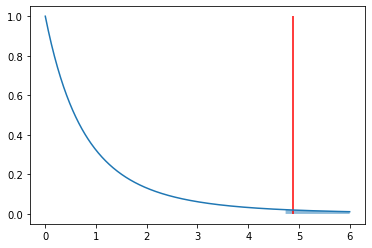

In [173]:
ox = np.linspace(0, 6, 500)
oy = stats.f.pdf(ox, k1, k2)

ox_right = np.linspace(t, 6, 100)
oy_right = stats.f.pdf(ox_right, k1, k2)

plt.plot(ox, oy)
plt.fill_between(ox_right, oy_right, alpha=0.5)
plt.vlines(F_task1, 0, oy.max(), color='red')

F-статистика находится в критической области, что значит что нулевая гипотеза не подтвердилась. Между переменными есть зависимость или __Уравнене регрессии значимо__

### __Задача 2__

Даны значения величины заработной платы заемщиков банка (`salary`) и значения их поведенческого кредитного скоринга (`scoring`):
```
salary = [35, 45, 190, 200, 40, 70, 54, 150, 120, 110]
scoring = [401, 574, 874, 919, 459, 739, 653, 902, 746, 832]
```
Возьмём в качестве признака значение `salary`, а в качестве целевой переменной - `scoring`.

1. Найдите коэффициенты линейной регрессии с помощью формул для парной регрессии, а затем с помощью метода наименьших квадратов.
2. Постройте `scatter plot` по данным и отметьте на нём прямую линейной регрессии, полученную в п. 1.
3. Посчитайте коэффициент детерминации.
4. Оцените построенное уравнение регрессии с помощью F-критерия Фишера.
5. Оцените значимость получившихся параметров уравнения регрессии и постройте для них доверительные интервалы с помощью t-статистики Стьюдента.
6. (доп) Посчитать среднюю ошибку аппроксимации

In [174]:
salary = np.array([35, 45, 190, 200, 40, 70, 54, 150, 120, 110])
scoring = np.array([401, 574, 874, 919, 459, 739, 653, 902, 746, 832])

In [206]:
# 1 Найдите коэффициенты линейной регрессии с помощью формул для парной регрессии, 
# а затем с помощью метода наименьших квадратов.
b = find_b(salary, scoring)
b_sq = find_b2(salary.reshape(-1, 1), scoring)
print(f'С помощью формул для парной регрессии: {b}\nс помощью метода наименьших квадратов: {b_sq}')

С помощью формул для парной регрессии: [444.1773573243596, 2.620538882402765]
с помощью метода наименьших квадратов: [444.17735732   2.62053888]


Коэффициент детерминации: 0.79


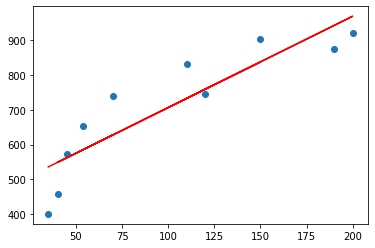

In [215]:
# 2. Постройте scatter plot по данным и отметьте на нём прямую линейной регрессии, полученную в п. 1.
plt.scatter(salary, scoring)
z = predict(b, salary)
plt.plot(salary, z, color='red')

print(f'Коэффициент детерминации: {round(np.corrcoef(salary, scoring)[0,1] ** 2, 2)}')
plt.show()

In [217]:
# 3. Посчитайте коэффициент детерминации.
R_task2 = np.corrcoef(salary, scoring)[0,1] ** 2
R_task2

0.7876386635293682

In [224]:
# 4. Оцените построенное уравнение регрессии с помощью F-критерия Фишера.
n_task2 = salary.shape[0]
m_task2 = 1
a_task2 = 0.05
k1 = m_task2
k2 = n_task2 - m_task2 - 1

t = stats.f.ppf(1 - a_task2, k1, k2)

F = R_task2 ** 2 * k2 / k1 / (1 - R_task2 ** 2)
print(f't = {t}\nF = {F}')
print('уравнение значимо' if t < F else 'уравнение не значимо')

t = 5.317655071578714
F = 13.073409088886347
уравнение значимо
